# Exploratory Data Analysis for Amazon's Top 50 Bestselling Books from 2010-2020
***
## *Contents*
1. [Overview](#overview)
2. [Importing Required Libraries](#import)
3. [Data Cleaning](#cleaning)
4. [Analysis](#analysis)
5. [Conclusions](#conclusion)
***

<a id='overview'></a>
## 1. *Overview*
This notebook explores a dataset containing the top 50 bestselling books on Amazon from the years 2010 to 2020 inclusive. Books title, author, rating, number of reviews, price, and year data are scraped from Amazon web pages and genre information is obtained using Google Books API. Webscraping and API calling process can be found in the accompanying file named *'amazon_scrape.py'*.

***
<a id='import'></a>
## 2. *Importing Required Libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")
sns.set_palette("YlGn")

***
<a id='cleaning'></a>
## 3. *Data Cleaning*

In [2]:
# Read data
df = pd.read_csv('Amazon_best_sellers_2010_2020_fiction_flag.csv', encoding='unicode_escape')
df.head()

,title,author,rating,reviews,price,year,fiction flag
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,27719,1.44,2016,False
1,11/22/63: A Novel,Stephen King,4.7,2588,2.81,2011,True
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,39960,7.31,2018,False
3,"1984 (Signet Classics), Book Cover May Vary",George Orwell,4.7,49411,0.86,2017,True
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Kids,4.8,15160,2.50,2019,False


In [3]:
# Checking size of dataset and columns dtypes
print(f'Data contains {df.shape[0]} records and {df.shape[1]} columns.')
df.dtypes

Data contains 546 records and 7 columns.


title            object
author           object
rating          float64
reviews           int64
price           float64
year              int64
fiction flag       bool
dtype: object

In [4]:
# Change 'fiction flag' column to a categorical input signifying Fiction or Non-Fiction genre
df.loc[df['fiction flag'] == True, 'fiction flag'] = 'Fiction'
df.loc[df['fiction flag'] == False, 'fiction flag'] = 'Non-Fiction'
df['fiction flag'] = df['fiction flag'].astype('category')
df['fiction flag'].dtype

CategoricalDtype(categories=['Fiction', 'Non-Fiction'], ordered=False, categories_dtype=object)

In [5]:
df.head()

,title,author,rating,reviews,price,year,fiction flag
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,27719,1.44,2016,Non-Fiction
1,11/22/63: A Novel,Stephen King,4.7,2588,2.81,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,39960,7.31,2018,Non-Fiction
3,"1984 (Signet Classics), Book Cover May Vary",George Orwell,4.7,49411,0.86,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Kids,4.8,15160,2.50,2019,Non-Fiction


In [6]:
# Check for any missing data in the dataset
df.isnull().sum()

title           0
author          0
rating          0
reviews         0
price           0
year            0
fiction flag    0
dtype: int64

In [7]:
# Check for duplicates in 'title' and 'author', ignore 'fiction flag' column as it only contains 'Fiction' and 'Non-Fiction'
for col in ['title','author']:
    if df[col].duplicated().any() == True:
        print(f'Column "{col}" contains duplicates')
    else:
        
        print(f'Column "{col}" contains no duplicates')

Column "title" contains duplicates
Column "author" contains duplicates


In [8]:
# Check for alphabet casing and spacing differences
for col in ['title','author']:
    print(f'"{col}" Original: {len(set(df[col]))}, Edited: {len(set(df[col].str.title().str.strip()))}')

# Make the required edits to standardise book/author names formatting
df.title = df.title.str.title().str.strip()

# Check author names
print(f'Original: {len(df.author.unique())}, Edited: {len(df.author.str.replace(" ","").replace(".","").replace(",","").unique())}')

"title" Original: 345, Edited: 344
"author" Original: 254, Edited: 254
Original: 254, Edited: 252


In [9]:
# Visually inspect the unique author names present in data set to find duplicates
print(df.author.sort_values().unique())

['Abraham Verghese' 'Adam Gasiewski' 'Adam Mansbach' 'Adam Wallace'
 'Adir Levy' 'Admiral William H. McRaven' 'Alex Michaelides'
 'Alice Schertle' 'Allie Brosh' 'Amelia Hepworth'
 'American Psychiatric Association' 'American Psychological Association'
 'Amor Towles' 'Amy Ramos' 'Amy Shields' 'Andy Weir' 'Angie Grace'
 'Angie Thomas' 'Ann Voskamp' 'Ann Whitford Paul' 'Anthony Bourdain'
 'Anthony Doerr' 'Atul Gawande' 'B. J. Novak' 'Barack Obama'
 'Bessel van der Kolk M.D.' 'Bill Martin Jr.' "Bill O'Reilly"
 'Blue Star Coloring' 'Bob Woodward' 'Brandon Stanton' 'BreneÌ\x81E Brown'
 'Brian Kilmeade' 'Brit Bennett' 'Bruce Springsteen' 'Carol S. Dweck'
 'Carole P. Roman' 'Celeste Ng' 'Charlaine Harris' 'Charles Duhigg'
 'Charles Krauthammer' 'Charlie Mackesy' 'Cheryl Strayed' 'Chip Gaines'
 'Chip Heath' 'Chris Cleave' 'Chris Kyle' 'Chrissy Teigen'
 'Christina Baker Kline' 'Christopher Paolini' 'Coloring Books for Adults'
 'Conor Riordan' 'Craig Smith' 'Crispin Boyer' 'Crystal Radke' 'DK'
 '

In [10]:
# George R.R. Martin and J.K. Rowling appears with two different spellings for their names, standardise to one spelling
df.replace('George R. R. Martin', 'George R.R. Martin', inplace = True)
df.replace('J. K. Rowling', 'J.K. Rowling', inplace = True)
print(f'Original: {len(df.author.unique())}, Edited: {len(df.author.str.replace(" ","").replace(".","").replace(",","").unique())}')

Original: 252, Edited: 252


In [11]:
# Check only 2010 - 2020 appear in the dataset
df.year.value_counts()

year
2018    50
2017    50
2019    50
2020    50
2015    50
2013    50
2012    50
2016    49
2011    49
2014    49
2010    49
Name: count, dtype: int64


In this dataset we expect 50 titles present for each year, however from the above we observe that this is not the case as there are years with only 49 titles present. This is due to removed listings for a title within the top 50 Amazon bestsellers in those years preventing the relevant information from being scraped.


In [12]:
df.tail()

,title,author,rating,reviews,price,year,fiction flag
541,Wrecking Ball (Diary Of A Wimpy Kid Book 14),Jeff Kinney,4.9,16016,1.74,2019,Fiction
542,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,28561,1.17,2019,Fiction
543,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,28561,1.17,2018,Fiction
544,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,28561,1.17,2017,Fiction
545,You Are A Badass: How To Stop Doubting Your Gr...,Jen Sincero,4.7,28561,1.17,2016,Fiction


We can observe that there are duplicates within the dataset if a title makes it to the top50 in different years. The scraped rating, reviews, and price data are the latest values as of scraping, not the values from the particular year the title made it to the top50. Hence, we will create a separate dataframe removing all the duplicated titles to supplement our analysis.

In [13]:
# Separate dataframe containing only unique titles
df_no_dup = df.drop_duplicates('title').reset_index().drop('index', axis = 1)
print(f'Data contains {len(df_no_dup)} books written by {len(df_no_dup.author.unique())} different authors')

Data contains 344 books written by 252 different authors


***
<a id='analysis'></a>
# 3. *Analysis*
In this section we will analyse the data and answer a few simple questions about the dataset:<br>
a. [Which author has the highest average rating?](#author-rating)<br>
b. [Which author has the most bestsellers?](#author-title)<br>
c. [Which book has the highest number of reviews?](#author-reviews)<br>
d. [Are ratings, number of reviews, prices, and genre correlated?](#correlation)<br>
e. [Are the distribution of ratings for Fiction and Non-Fiction books the same?](#testing)<br>

This notebook will not be exploring the changes to the books' statistics throughout the years as the dataset only contains the latest statistics as seen in the previous section with Jen Sincero's bestseller 'You Are A Badass'.

<a id='author-rating'></a>
### a. *Which author has the highest average rating?*
When considering highest average ratings, we can look from it from two different angles:<br>
(i) Highest average rating with any number of bestsellers<br>
(ii) Highest average rating with a minimum number of bestsellers (for this analysis we will arbitrarily select authors with a minimum of 3 bestsellers)<br>

By analysing the data in this manner, we can see a list of top authors that may have highly rated 'one-hit wonders', and a list of top authors that have released multiple bestsellers that are more consistently highly rated.

In [14]:
# (i) Highest average rating for authors with any number of bestsellers
top_authors = df.groupby('author').agg(count=('author','size'), mean_rating=('rating','mean')).sort_values('mean_rating', ascending=False).reset_index()
top_authors.head()

,author,count,mean_rating
0,Dav Pilkey,8,4.9
1,Lin-Manuel Miranda,1,4.9
2,Mark R. Levin,1,4.9
3,Patrick Thorpe,1,4.9
4,Pete Souza,1,4.9


In [15]:
# (ii) Highest average rating for authors with at least 3 bestsellers
top_authors = df.groupby('author').agg(count=('author','size'), mean_rating=('rating','mean'))
top_authors = top_authors.loc[top_authors['count']>3].sort_values(['mean_rating','count'], ascending=False).reset_index()
top_authors.head()

,author,count,mean_rating
0,Dav Pilkey,8,4.9
1,Eric Carle,8,4.9
2,Sarah Young,6,4.9
3,Bill Martin Jr.,4,4.9
4,Emily Winfield Martin,4,4.9


For both cases we see that there are overlaps in the authors with highest average ratings in both cases, and the top authors all have an average rating of 4.9.

<a id='author-title'></a>
### b. *Which author has the most bestsellers?*
Similarly, in this case we can look at this question from two perspective:<br>
(i) Authors that has made it to the bestselling list the most times<br>
(ii) Authors that has the most number of unique titles in the bestselling list<br>

By analysing the data in this manner we can obtain separate the lists of authors who has made it to the bestselling lists the most times, and the lists of authors who has written the most bestsellers.

In [16]:
# (i) Authors that has made it to the bestselling list the most times
dict_appearance = df.author.value_counts().to_dict()
number_of_appearances = sorted(dict_appearance.items(), key = lambda x:x[1], reverse = True)
x = [number_of_appearances[i][0] for i in range(10)]
y = [number_of_appearances[i][1] for i in range(10)]

Text(0.5, 0, 'Author')

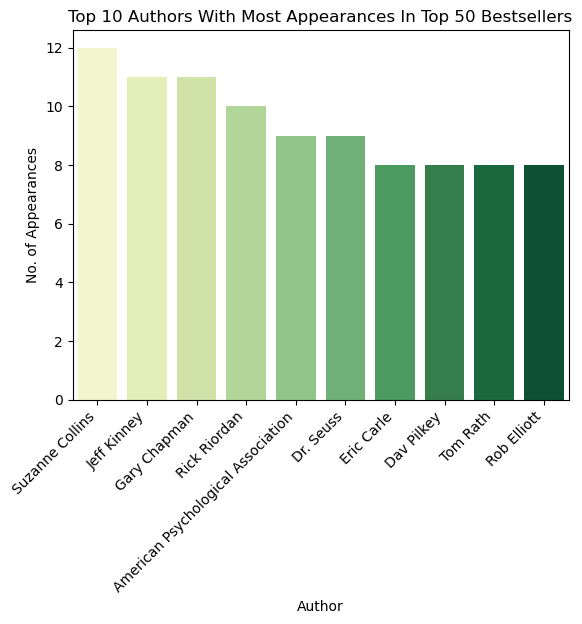

In [17]:
sns.barplot(x=x, y=y, palette="YlGn")
plt.title('Top 10 Authors With Most Appearances In Top 50 Bestsellers')
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('No. of Appearances')
plt.xlabel('Author')

In [18]:
# (ii) Authors that has the most number of unique titles in the bestselling list
dict_unique_books = df_no_dup.author.value_counts().to_dict()
number_of_unique_books = sorted(dict_unique_books.items(), key = lambda x:x[1], reverse = True) # compare to previous list authors like Jeff Kinney have bestselling books that appear in top50 for a year while Suzanne Collins have books that appear in multiple years

x = [number_of_unique_books[i][0] for i in range(10)]
y = [number_of_unique_books[i][1] for i in range(10)]

Text(0.5, 0, 'Author')

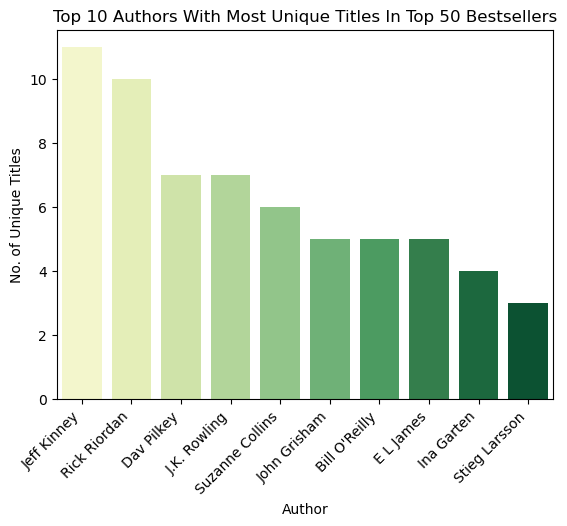

In [19]:
sns.barplot(x=x, y=y, palette="YlGn")
plt.title('Top 10 Authors With Most Unique Titles In Top 50 Bestsellers')
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('No. of Unique Titles')
plt.xlabel('Author')

In scenario (i) we see that Suzanne Collins has appeared 12 times while Jeff Kinney has appeared 11 times in the bestselling lists, while in scenario (ii) we see that Suzanne Collins has 6 unique titles while Jeff Kinney has 11 unique titles in the bestselling lists. This suggests that Jeff Kinney's bestsellers are popular for their respective bestselling years while Suzanne Collins' bestsellers may be popular for a longer period of time, with some titles appearing in the bestselling lists for multiple years.

<a id='author-reviews'></a>
### c. *Which book has the highest number of reviews?*

In [20]:
df_no_dup.sort_values('reviews', ascending = False).reset_index().head(20)

,index,title,author,rating,reviews,price,year,fiction flag
0,77,Educated: A Memoir,Tara Westover,4.6,1697195,19.60,2019,Non-Fiction
1,335,Where The Crawdads Sing,Delia Owens,4.6,1697195,2.32,2019,Fiction
2,325,Untamed,Glennon Doyle,4.6,1697195,4.99,2020,Non-Fiction
3,295,The Splendid And The Vile: A Saga Of Churchill...,Erik Larson,4.6,1697195,7.67,2020,Non-Fiction
4,246,The Girl Who Played With Fire (Millennium Series),Stieg Larsson,4.6,1697194,0.02,2010,Fiction
5,316,To Kill A Mockingbird,Harper Lee,4.6,1697194,1.23,2019,Fiction
6,161,Looking For Alaska,John Green,4.6,1697194,0.35,2014,Fiction
7,222,The Art Of Racing In The Rain: A Novel,Garth Stein,4.6,1697194,0.25,2010,Fiction
8,223,The Ballad Of Songbirds And Snakes (A Hunger G...,Suzanne Collins,4.6,1697194,3.76,2020,Fiction
9,229,The Book Thief,Markus Zusak,4.6,1697194,0.35,2014,Fiction


Looking at the top 20 books with the highest number of reviews, we observe that the top 15 books have the same number of reviews at approximately 1.7 million reviews. The next highest number of reviews is approximately 0.1 million reviews. Upon further inspection on the product pages on Amazon we can see that for the top 15 books are part of a group of products with a shared ratings/reviews section resulting in the significantly higher number of reviews. Separation of the ratings/reviews section to their respective products could not be achieved hence these books will be removed for analysis henceforth.

In [21]:
# Which book has the highest number of reviews?
number_of_reviews = df_no_dup.loc[df_no_dup.reviews < 1000000]

x = number_of_reviews.sort_values('reviews', ascending = False).head(5)['title']
x = x.replace("Too Much And Never Enough: How My Family Created The World'S Most Dangerous Man", "Too Much And Never Enough")
y = number_of_reviews.sort_values('reviews', ascending = False).head(5)['reviews']

Text(0.5, 0, 'Book')

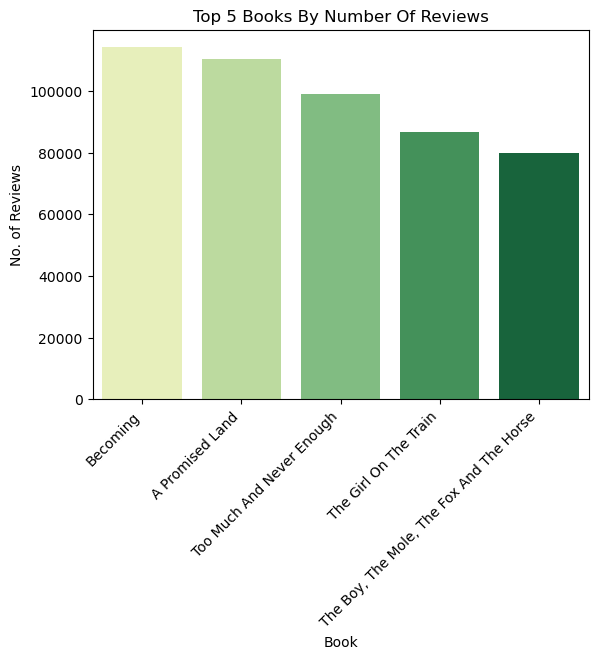

In [22]:
sns.barplot(x=x, y=y, palette="YlGn")
plt.title('Top 5 Books By Number Of Reviews')
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('No. of Reviews')
plt.xlabel('Book')

<a id='correlation'></a>
### *d. Are ratings, number of reviews, prices, and genre correlated?*
First, we shall look at some descriptive statistics.

Text(0.5, 1.0, 'Percentage Of Books Per Genre')

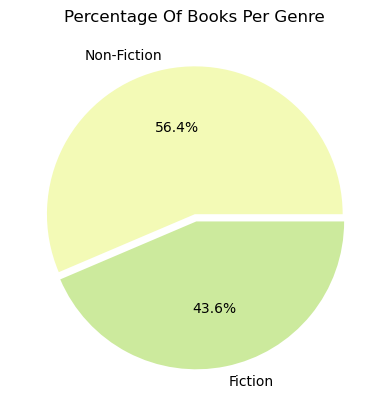

In [23]:
# Pie chart for genre
number_genre = df.groupby('fiction flag')[['title']].count().sort_values('title', ascending = False).reset_index()
plt.pie(number_genre['title'], labels=['Non-Fiction','Fiction'], autopct='%1.1f%%', explode = (0,0.05))
plt.title('Percentage Of Books Per Genre')

In [24]:
# Box plots for rating, number of reviews, price
number_of_reviews.describe()

,rating,reviews,price,year
count,329.000000,329.000000,329.000000,329.000000
mean,4.644073,17777.963526,9.323374,2015.012158
std,0.213357,17954.810581,10.120740,3.270317
min,3.300000,251.000000,0.250000,2010.000000
25%,4.500000,5793.000000,1.360000,2012.000000
50%,4.700000,12103.000000,7.460000,2015.000000
75%,4.800000,23500.000000,13.950000,2018.000000
max,4.900000,114201.000000,81.980000,2020.000000


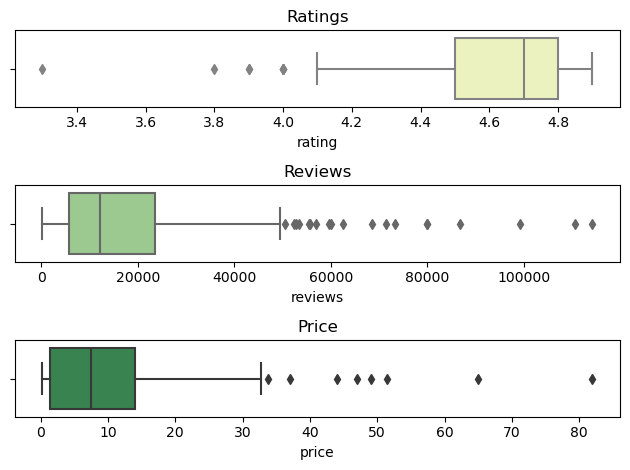

In [25]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1)
sns.boxplot(data=number_of_reviews, x='rating', ax=ax1, color='#f3fab6')
ax1.set_title('Ratings')
sns.boxplot(data=number_of_reviews, x='reviews', ax=ax2, color='#97d385')
ax2.set_title('Reviews')
sns.boxplot(data=number_of_reviews, x='price', ax=ax3, color='#2c8f4b')
ax3.set_title('Price')
plt.tight_layout()
plt.show()

*Genre:*<br>
1. We observe that there are more Non-Fiction bestsellers than Fiction bestsellers.


For rating, reviews, and price we observe that data is not distributed normally<br>

*Rating:*<br>
1. Small number of outliers with ratings below the 25 percentile of 4.1 rating.

*Reviews:*<br>
1. Data spans a wide range.
2. Small number of outliers with ratings significantly above the 75 percentile of 50k.

*Price:*<br>
1. Small number of outliers with prices significantly above the 75 percentile of $33.

Using a pairplot matrix, we can see if there is any correlation between these 4 variables.

In [26]:
number_of_reviews

,title,author,rating,reviews,price,year,fiction flag
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,27719,1.44,2016,Non-Fiction
1,11/22/63: A Novel,Stephen King,4.7,2588,2.81,2011,Fiction
2,12 Rules For Life: An Antidote To Chaos,Jordan B. Peterson,4.7,39960,7.31,2018,Non-Fiction
3,"1984 (Signet Classics), Book Cover May Vary",George Orwell,4.7,49411,0.86,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Kids,4.8,15160,2.50,2019,Non-Fiction
...,...,...,...,...,...,...,...
339,Winter Of The World: Book Two Of The Century T...,Ken Follett,4.6,14360,12.97,2012,Fiction
340,Women Food And God: An Unexpected Path To Almo...,Geneen Roth,4.3,1721,15.88,2010,Non-Fiction
341,Wonder,R. J. Palacio,4.8,30845,0.35,2017,Fiction
342,Wrecking Ball (Diary Of A Wimpy Kid Book 14),Jeff Kinney,4.9,16016,1.74,2019,Fiction


In [27]:
# Pairplot for correlation
index_vals = number_of_reviews['fiction flag'].astype('category').cat.codes

Text(0.5, 1.0, 'Pairplot of Book Statistics')

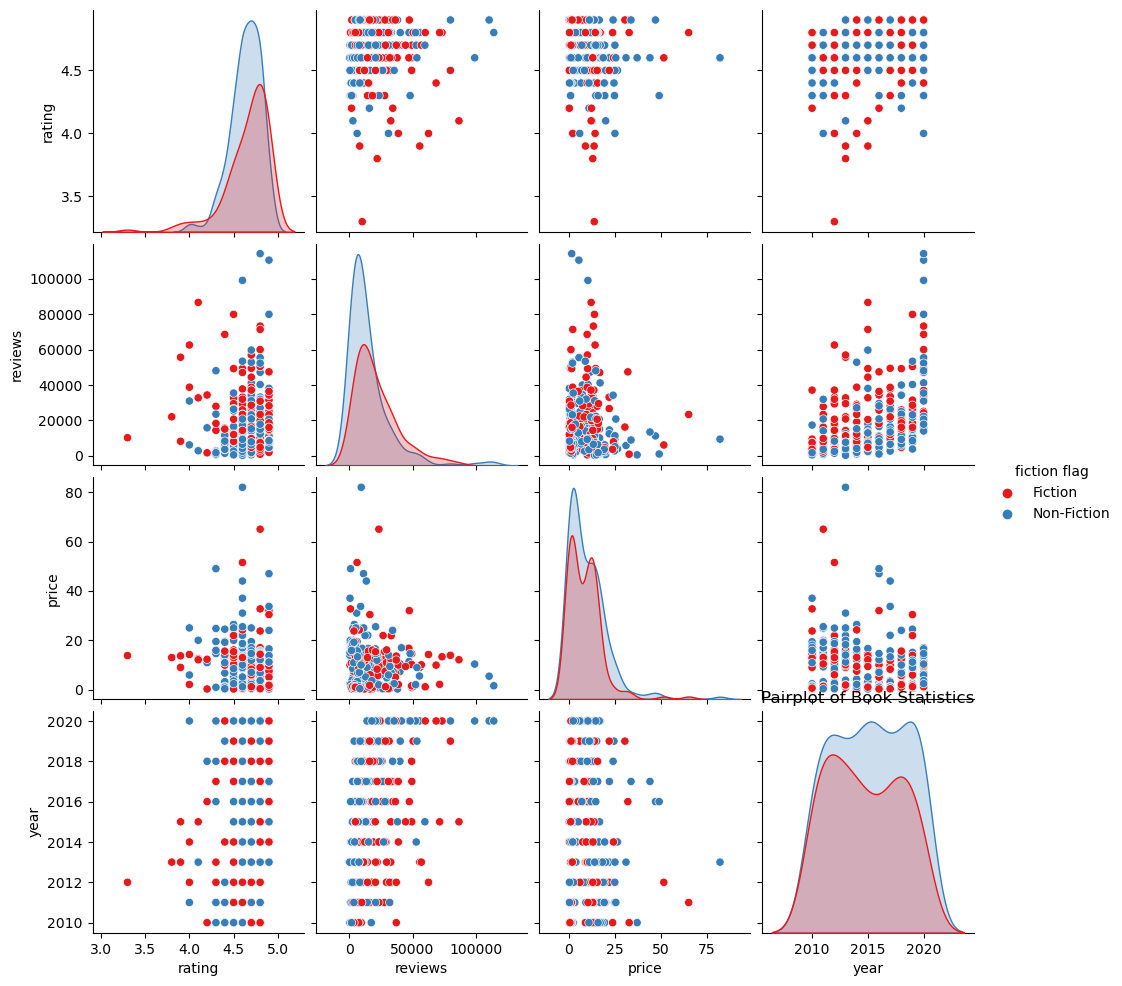

In [28]:
sns.pairplot(number_of_reviews, palette='Set1', hue='fiction flag')
plt.title("Pairplot of Book Statistics")

From the above, we observe no obvious correlation between the variable. However, we can see that the range of ratings between Fiction and Non-Fiction bestsellers differ and shall analyse this difference.

<a id='testing'></a>
### e. *Are the distribution of ratings for Fiction and Non-Fiction books the same?*
Comparison of the distributions will be conducted in two parts:<br>
(i) Testing normality with Shapiro-Wilk test of normality<br>
(ii) Testing statistical differences between the two distributions with Mann-Whitney U test<br>

First, Shapiro-Wilk test will be used to show that ratings are not normally distributed. The bestsellers are than split into two groups, Fiction and Non-Fiction. Mann-Whitney U test is then used to test for statistical differences between the distribution of ratings in these two groups

In [29]:
# (i) Testing normality with Shapiro-Wilk test of normality
alpha = 0.05
stat, pval = shapiro(number_of_reviews['rating'])
print('Statistic:', f'{stat:.3f}')
print('P-value:', f'{pval:.20f}')
if pval > alpha:
    print('Data is distributed normally')
else:
    print('Data is not distributed normally')

# Split bestsellers into two groups
fiction = number_of_reviews[number_of_reviews['fiction flag'] == 'Fiction']['rating']
nonfiction = number_of_reviews[number_of_reviews['fiction flag'] == 'Non-Fiction']['rating']

Statistic: 0.858
P-value: 0.00000000000000009052
Data is not distributed normally


In [30]:
# (ii) Testing statistical difference between the two distributions with Mann-Whitney U test
stat, pval = mannwhitneyu(nonfiction, fiction)
print('Statistic:', f'{stat:.0f}')
print('P-value:', f'{pval:.5f}')
if pval > alpha:
    print('No significant difference between the two groups')
else:
    print('Significant difference between the two groups')

Statistic: 11205
P-value: 0.01377
Significant difference between the two groups


Text(0.5, 1.0, 'Distribution of Ratings between Fiction vs Non-Fiction')

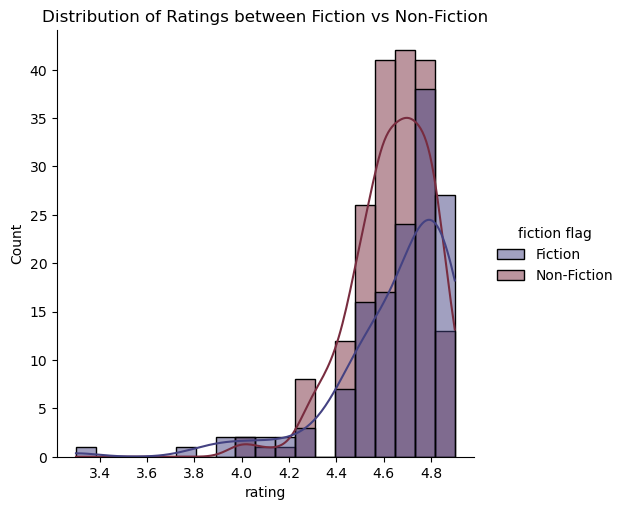

In [31]:
sns.displot(data=number_of_reviews, x='rating', hue='fiction flag', palette='icefire', kde=True)
plt.title('Distribution of Ratings between Fiction vs Non-Fiction')

Based on the results, we can argue that readers evalute books differently based on the genre, with preferences given to works of Fiction.

***
<a id='conclusion'></a>
## 4. *Conclusion*
In this notebook, our analysis have evaluated the best performing authors and titles in the dataset, and some different perspectives that we can look at the dataset from to obtain additional insights for general questions like 'Which author has the highest average rating'. We also observe that Non-Fiction titles form the majority of bestsellers, but Fiction titles score statistically higher ratings on average suggesting that readers may like works of fiction more.